# UNET

### Importamos todas las instancias necesarias 📚 📦

In [ ]:
# Bibliotecas estándar de Python
import os
import random

# Bibliotecas para manipulación de datos y visualización
import numpy as np
import matplotlib.pyplot as plt

# Bibliotecas de procesamiento de imágenes
from PIL import Image
import PIL

# PyTorch y sus submódulos
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T

Freezing and Thawing Layers and Parameters

### GPU ⚙️ 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device} está disponible")

cuda está disponible


### Transformaciones

In [3]:
transform_data = T.Compose([
                    T.Resize((224, 224)),               # Redimensionar a 224x224 píxeles
                    T.ToTensor(),                       # Convertir a tensor de PyTorch                    
])

### Dataset and Dataloader 💾

In [4]:
# Ruta base (directorio actual donde se encuentra este notebook)
PATH = os.path.dirname(os.path.abspath('__file__'))  # Directorio actual

# Rutas específicas para los datos
TRAIN_PATH = os.path.join(PATH, 'data/train/')
TRAIN_MASKS_PATH = os.path.join(PATH, 'data/train_masks/')
TEST_PATH = os.path.join(PATH, 'data/test/')

#### DataSet

In [5]:
# Definir la transformación a tensor
to_tensor = T.ToTensor()

class Car_Dataset(Dataset):
    def __init__(self, data, masks=None, imgs_transform=None, mask_transform=None):        
        self.train_data = data      
        self.train_masks = masks
        
        self.imgs_transform = imgs_transform
        self.mask_transform = mask_transform
        
        # Ordenamos las imágenes para asegurar que coincidan con las máscaras
        self.images = sorted(os.listdir(self.train_data))
        
        # También necesitamos ordenar las máscaras si existen
        if self.train_masks is not None:
            self.masks = sorted(os.listdir(self.train_masks))
        
    def __len__(self):
        if self.train_masks is not None:
            # Si hay máscaras, aseguramos que la longitud sea la misma
            assert len(self.images) == len(self.masks), 'ATENCIÓN. Número de imágenes y máscaras distintas'
                
        return len(self.images)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        
        # (1) Si hay que aplicar transformaciones lo pasamos por la transformación
        # (2) Si no hay que aplicar transformaciones, al menos convertimos a tensor de PyTorch
        
        # Imágenes
        if self.imgs_transform is not None:     # (1) 
            img = self.imgs_transform(img)
        else:                                   # (2) 
            img = to_tensor(img)
        
        # Máscaras
        if self.train_masks is not None:        # Si hay máscaras (imágenes de entrenamiento y validación)         
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transform is not None: # (1)
                mask = self.mask_transform(mask)
            else:                               # (2)     
                mask = to_tensor(mask)
                             
            # Normalización para asegurarnos de que la máscara está entre 0 y 1
            mask_max = mask.max().item()        
            mask = mask / mask_max        
        else:
            return img
        
        return img, mask

#### DataLoaders

In [6]:
full_dataset = Car_Dataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           imgs_transform=transform_data,
                           mask_transform=transform_data)

BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)     # Tomaremos el 80% de los datos para entrenamiento
VAL_SIZE = len(full_dataset) - TRAIN_SIZE   # El resto para validación

print(TRAIN_SIZE, VAL_SIZE)



4070 1018


In [12]:
# Cargamos nuestros datasets de manera aleatoria
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

In [ ]:
# Cargamos nuestros dataloaders
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True)

In [16]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


***torch.Size([32, 3, 224, 224])*** --> Tensores de 4 dimensiones:
> 32: Tamaño del batch (número de imágenes procesadas a la vez)

> 3: Número de canales de color (RGB - Rojo, Verde, Azul)

>224: Altura de cada imagen en píxeles

>224: Anchura de cada imagen en píxeles

### Visualización de datos

In [17]:
# Imprimimos una muestras de las dimensiones de las imágenes y máscaras
# de esta manera podemos verificar que las dimensiones son correctas y coinciden entre imágenes y máscaras
for i, (x, y) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"  Imágenes: {x.shape}")
    print(f"  Máscaras: {y.shape}")
    if i == 3: break

Batch 1:
  Imágenes: torch.Size([32, 3, 224, 224])
  Máscaras: torch.Size([32, 1, 224, 224])
Batch 2:
  Imágenes: torch.Size([32, 3, 224, 224])
  Máscaras: torch.Size([32, 1, 224, 224])
Batch 3:
  Imágenes: torch.Size([32, 3, 224, 224])
  Máscaras: torch.Size([32, 1, 224, 224])
Batch 4:
  Imágenes: torch.Size([32, 3, 224, 224])
  Máscaras: torch.Size([32, 1, 224, 224])


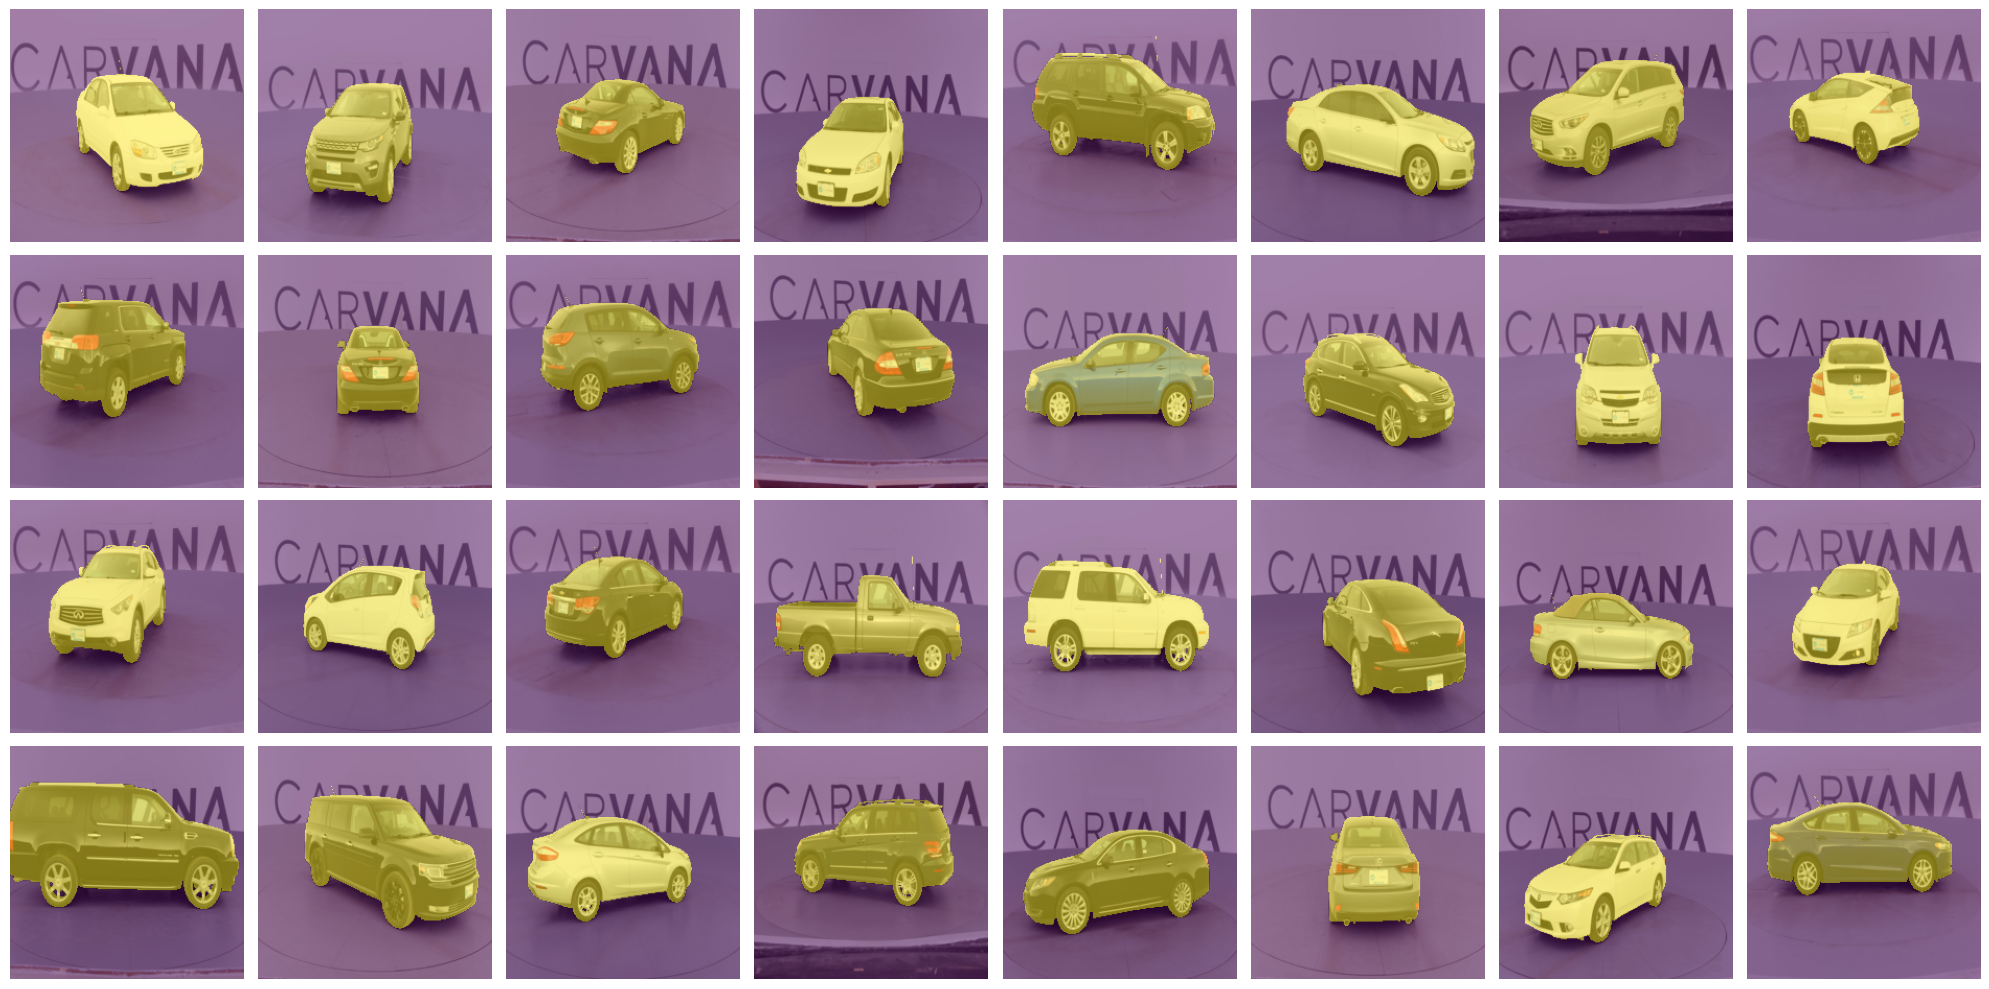

In [18]:
# Imprimimos una muestra de imágenes y máscaras de manera superpuesta
# de esta manera podemos verificar que se están cargando correctamente y coinciden
imgs, masks = next(iter(train_loader))

def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)                          # 4 filas y 8 columnas
        img=imgs[i,...].permute(1,2,0).numpy()          
        mask = masks[i,...].permute(1,2,0).numpy()      
        plt.imshow(img)                                 # Mostramos la imagen
        plt.imshow(mask, alpha=0.5)                     # Mostramos la máscara con transparencia

        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)


### Accuracy

In [32]:
def dice(preds, targets, smooth=1e-6):
    preds = preds.contiguous().view(-1)
    targets = targets.contiguous().view(-1)
    
    intersection = (preds * targets).sum()
    dice_score = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    
    return dice_score.item()

def iou(preds, targets, smooth=1e-6):
    preds = preds.contiguous().view(-1)
    targets = targets.contiguous().view(-1)
    
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    
    return iou_score.item()

# Función accuracy
def accuracy(model, loader):
    model.eval()
    cost = 0
    correct = 0
    total = 0
    dice_score_acum = 0
    iou_score_acum = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)  # Convertir a float32
            y = y.to(device, dtype=torch.long).squeeze(1)  # Convertir a long y eliminar la dimensión de canal            
            
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            
            # Accuracy standard (no óptimo para segmentación pero ayuda a dar una idea)
            predictions = torch.argmax(scores, dim=1)
            correct += (predictions == y).sum().item()
            total += torch.numel(predictions)
            
            # Métricas de segmentación
            dice_score_acum += dice(predictions, y)
            iou_score_acum += iou(predictions, y)
    
    accuracy = correct / total
    dice_score = dice_score_acum / len(loader)
    iou_score = iou_score_acum / len(loader)
    
    return cost / len(loader), accuracy, dice_score, iou_score

### Buscador de Learning Rate óptimo

In [20]:
def find_lr(model, optimizer, start_val=1e-6, end_val=1, beta = 0.99, loader=train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimizer.param_groups[0]['lr'] = lr 
    avg_loss, loss, acc, = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimizer.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        
        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)

        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here({i, cost.item()})')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())

        losses.append(avg_loss)
        log_lrs.append(lr)
        
        cost.backward()
        optimizer.step()
        
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

### Train Loop

In [21]:
def train(model, optimizer, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device)
    print(f"Modelo en dispositivo: {next(model.parameters()).device}")  # Verificar dispositivo del modelo    
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0
        for i, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device, dtype=torch.float32)               # Convertir a float32
            y = y.to(device, dtype=torch.long).squeeze(1)       # Convertir a long y eliminar la dimensión de canal            
            
            scores = model(x)                                   # Forward pass
            cost = F.cross_entropy(input=scores, target=y)      # Calcular la función de pérdida
            optimizer.zero_grad()                               # Reiniciar los gradientes
            cost.backward()                                     # Backward pass
            optimizer.step()                                    # Actualizar los pesos 
            
            if scheduler: 
                scheduler.step()                      
            
            train_predictions = torch.argmax(scores, dim=1)             # Nos quedamos con el valor máximo de las dos salidas (probabilidades) que nos da el modelo en la salida
            train_correct_num += (train_predictions == y).sum().item()  # Acumulamos el número de aciertos
            train_total += torch.numel(train_predictions)               # Acumulamos el número total de píxeles 
            train_cost_acum += cost.item()                              # Acumulamos el coste
                        
            if i%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)  # Evaluar el modelo en el conjunto de validación cada 'store_ever' ciclos para evitar que se ralentice el entrenamiento
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/i
                print(f"Epoch {epoch+1}/{epochs}, Batch {i}, "
                      f"Train Cost: {train_cost_every:.4f}, "
                      f"Train Accuracy: {train_acc:.4f}, "
                      f"Validation Cost: {val_cost:.4f}, "
                      f"Validation Accuracy: {val_acc:.4f}, "
                      f"DICE: {dice:.4f}, "
                      f"IoU: {iou:.4f}")                
                
                #Save data
                #train_acc_history.append(train_acc)
                #train_cost_history.append(train_cost_every)
        #train_acc = float(train_correct_num)/train_total
        #train_cost_every = float(train_cost_acum)/len(train_loader)
        # return train_acc_history, train_cost_history

### Modelo U-NET

![Arquitectura U-NET](UNET_arquitectura.png)

#### Componentes del Encoder en U-NET
##### Primera capa de contracción:
- Dos convoluciones 3×3 (con activación ReLU)
- Un max pooling 2×2 (stride 2) para reducir la resolución a la mitad
##### Segunda capa de contracción:
- Dos convoluciones 3×3 (con activación ReLU)
- Un max pooling 2×2 (stride 2) para reducir la resolución nuevamente
##### Tercera capa de contracción:
- Dos convoluciones 3×3 (con activación ReLU)
- Un max pooling 2×2 (stride 2) para reducir la resolución
##### Cuarta capa de contracción:
- Dos convoluciones 3×3 (con activación ReLU)
- Un max pooling 2×2 (stride 2) para reducir la resolución
##### Capa inferior (fondo de la "U"):
- Dos convoluciones 3×3 (con activación ReLU)

> En cada nivel del encoder, el número de filtros (canales) se duplica después de cada max pooling, iniciando típicamente con 64 filtros en la primera capa y llegando a 1024 en la capa inferior.

In [22]:
# Simplificaremos el código de la red U-Net construyendo bloques repetitivos
# Conv_3_k: bloque de convolución con un kernel 3x3
# Double_Conv: bloque de doble convolución que se repite en cada "piso" de la U-Net
# Down_Conv: bloque que contiene Double_Conv + Pooling
class Conv_3_k(nn.Module):  
    """Bloque de convolución con un kernel 3x3"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):        
        return self.conv1(x)

class Double_Conv(nn.Module):
    """Bloque de doble convolución para U-Net"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
                                Conv_3_k(in_channels, out_channels),
                                nn.BatchNorm2d(out_channels),
                                nn.ReLU(),
                                Conv_3_k(out_channels, out_channels),
                                nn.BatchNorm2d(out_channels),
                                nn.ReLU()                                
                            )
            
    def forward(self, x):
        return self.double_conv(x)
    
class Down_Conv(nn.Module):
    """Bloque para hacer Max pooling y convolución"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Empezaremos con un bloque de pooling porque la salida de la convolución será la que linquemos con 
        # el otro "piso" en la etapa de decodificación
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(in_channels, out_channels)  
                        )
        
    def forward(self, x):        
        return self.encoder(x)
    
class Up_Conv(nn.Module):
    """Bloque para la etapa de decodificación"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #Upsample va a recibir la salida de la convolución de la etapa de codificación
        # y la salida de la convolución de la etapa de decodificación
        # por eso el out_chanels indicamos in_channels/2
        self.upsample_layer = nn.Sequential(
                            nn.Upsample(scale_factor=2, mode='bicubic'),  # Upsample scale_factor=2 duplica dimensiones
                            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, stride=1),            
                        )
        self.decoder = Double_Conv(in_channels, out_channels)

    def forward(self, x1, x2):
        """
        x1: salida de la etapa de decodificación
        x2: salida de la etapa de codificación
        """        
        x1 = self.upsample_layer(x1)
        x = torch.cat((x2,x1), dim=1)       # La dimensión 1 es la de los canales          
        return self.decoder(x)  # Concatenación y convolución

#### Construimos la U-Net con los bloques que hemos definido previamente
![Arquitectura U-NET](UNET_arquitectura_2.png)

In [23]:
class U_NET(nn.Module):
    
    def __init__(self, in_channels, channels, num_classes):
        super().__init__()
        # Encoder
        self.input_conv = Double_Conv(in_channels, channels)  # Primer bloque de convolución #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels)          # Primer bloque de pooling y convolución #128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels)        # Segundo bloque de pooling y convolución #256, 56, 56  
        self.down_conv3 = Down_Conv(4*channels, 8*channels)        # Tercer bloque de pooling y convolución #512, 28, 28
        
        # Bottleneck
        self.middle_conv = Down_Conv(8*channels, 16*channels)       # Cuarto bloque de pooling y convolución #1024, 14, 14

        # Decoder
        self.up_conv1 = Up_Conv(16*channels, 8*channels)            # Primer bloque de decodificación #512, 28, 28
        self.up_conv2 = Up_Conv(8*channels, 4*channels)             # Segundo bloque de decodificación #256, 56, 56
        self.up_conv3 = Up_Conv(4*channels, 2*channels)             # Tercer bloque de decodificación #128, 112, 112
        self.up_conv4 = Up_Conv(2*channels, channels)               # Cuarto bloque de decodificación #64, 224, 224

        # Output
        self.out_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)

    def forward(self, x):        
        x1 = self.input_conv(x)           # Primer bloque de convolución
        x2 = self.down_conv1(x1)           # Primer bloque de pooling y convolución
        x3 = self.down_conv2(x2)           # Segundo bloque de pooling y convolución
        x4 = self.down_conv3(x3)           # Tercer bloque de pooling y convolución
                
        x5 = self.middle_conv(x4)          # Cuarto bloque de pooling y convolución
        
        u1 = self.up_conv1(x5, x4)         
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)
        
        return self.out_conv(u4)



A continuación podemos verificar que las dimensiones de nuestra implementación funciona.
Debería arrojarnos un tensor de salida (32, 2, 224, 224)

In [24]:
def test():
    x = torch.randn((32, 3, 224, 224))  # Batch de 32 imágenes de 3 canales (RGB) y tamaño 224x224
    model = U_NET(3, 64, 2)  # Definimos el modelo U-Net
    return model(x)

prediction = test()
print("Predicción:", prediction.shape)  # Debería ser (32, 2, 224, 224) para 2 clases

Predicción: torch.Size([32, 2, 224, 224])


### Entrenamiento del modelo

#### Buscamos el learning rate óptimo de partida

In [25]:
torch.manual_seed(42)
model = U_NET(3,4,2)
optimizer = torch.optim.SGD(model.parameters(), 
                           lr=1e-2, 
                           momentum=0.95, 
                           weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, 
                                    optimizer, 
                                    start_val=1e-6, 
                                    end_val=10)

# Mostramos los valores de loss y learnin rate
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.title('Learning Rate vs Loss')
plt.show()

cost:0.7895, lr: 0.0000, acc: 0.2035
cost:0.7930, lr: 0.0000, acc: 0.1981
cost:0.8028, lr: 0.0000, acc: 0.1902
cost:0.7857, lr: 0.0000, acc: 0.2098
cost:0.7888, lr: 0.0000, acc: 0.2023
cost:0.8036, lr: 0.0000, acc: 0.1891
cost:0.7938, lr: 0.0000, acc: 0.1985
cost:0.7895, lr: 0.0000, acc: 0.1980
cost:0.7879, lr: 0.0000, acc: 0.2024
cost:0.7948, lr: 0.0000, acc: 0.1981
cost:0.7933, lr: 0.0000, acc: 0.2004
cost:0.7986, lr: 0.0000, acc: 0.1952
cost:0.7971, lr: 0.0000, acc: 0.1972
cost:0.8026, lr: 0.0000, acc: 0.1900
cost:0.7918, lr: 0.0000, acc: 0.2012
cost:0.7964, lr: 0.0000, acc: 0.1943
cost:0.7914, lr: 0.0000, acc: 0.2028
cost:0.7858, lr: 0.0000, acc: 0.2045
cost:0.7917, lr: 0.0000, acc: 0.2034
cost:0.7820, lr: 0.0000, acc: 0.2113
cost:0.7994, lr: 0.0000, acc: 0.1934
cost:0.7887, lr: 0.0000, acc: 0.2052
cost:0.7840, lr: 0.0000, acc: 0.2077
cost:0.7865, lr: 0.0000, acc: 0.2038
cost:0.8076, lr: 0.0000, acc: 0.1842
cost:0.8010, lr: 0.0000, acc: 0.1878
cost:0.7969, lr: 0.0000, acc: 0.1936
c

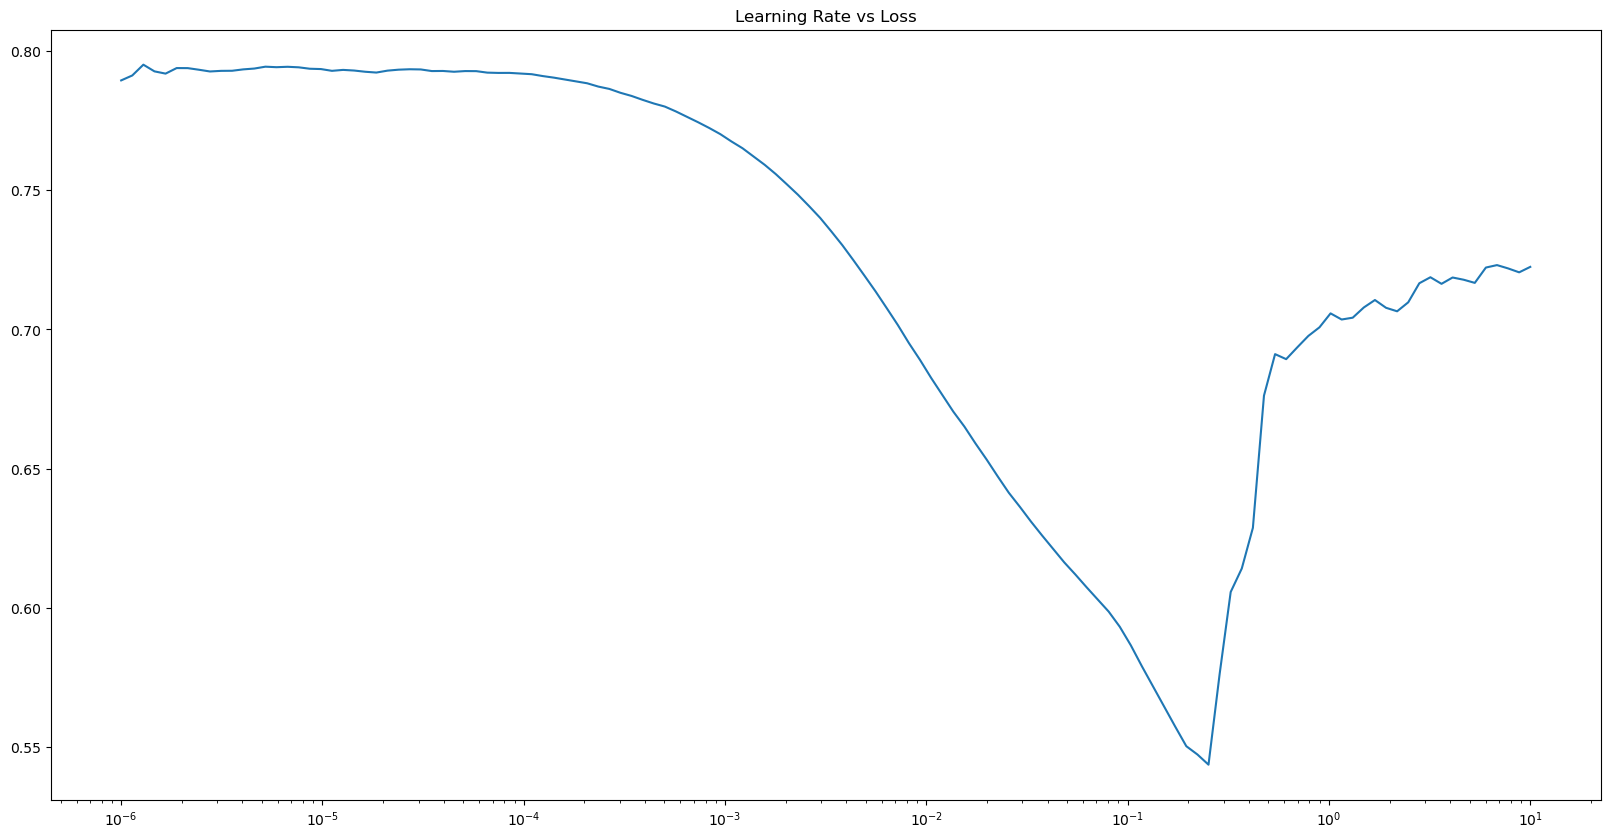

In [26]:
# Mostramos los valores de loss y learnin rate 
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.title('Learning Rate vs Loss')
plt.show()

In [36]:
# Definimos el optimizador y el scheduler
learning_rate = 0.05
epochs = 1
torch.manual_seed(42)
model = U_NET(3,64,2)
optimizer = torch.optim.SGD(model.parameters(), 
                           lr=learning_rate, 
                           momentum=0.95, 
                           weight_decay=1e-4)

total_steps = len(train_loader) * epochs            # Calcular el número total de pasos
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=total_steps)

'''scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=learning_rate,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs,
                                                pct_start=0.43,
                                                div_factor=10,
                                                final_div_factor=1e3,
                                                three_phase=True)'''
                         

'scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, \n                                                max_lr=learning_rate,\n                                                steps_per_epoch=len(train_loader),\n                                                epochs=epochs,\n                                                pct_start=0.43,\n                                                div_factor=10,\n                                                final_div_factor=1e3,\n                                                three_phase=True)'

### Graficamos las imágenes con las predicciones del modelo

torch.Size([32, 224, 224])


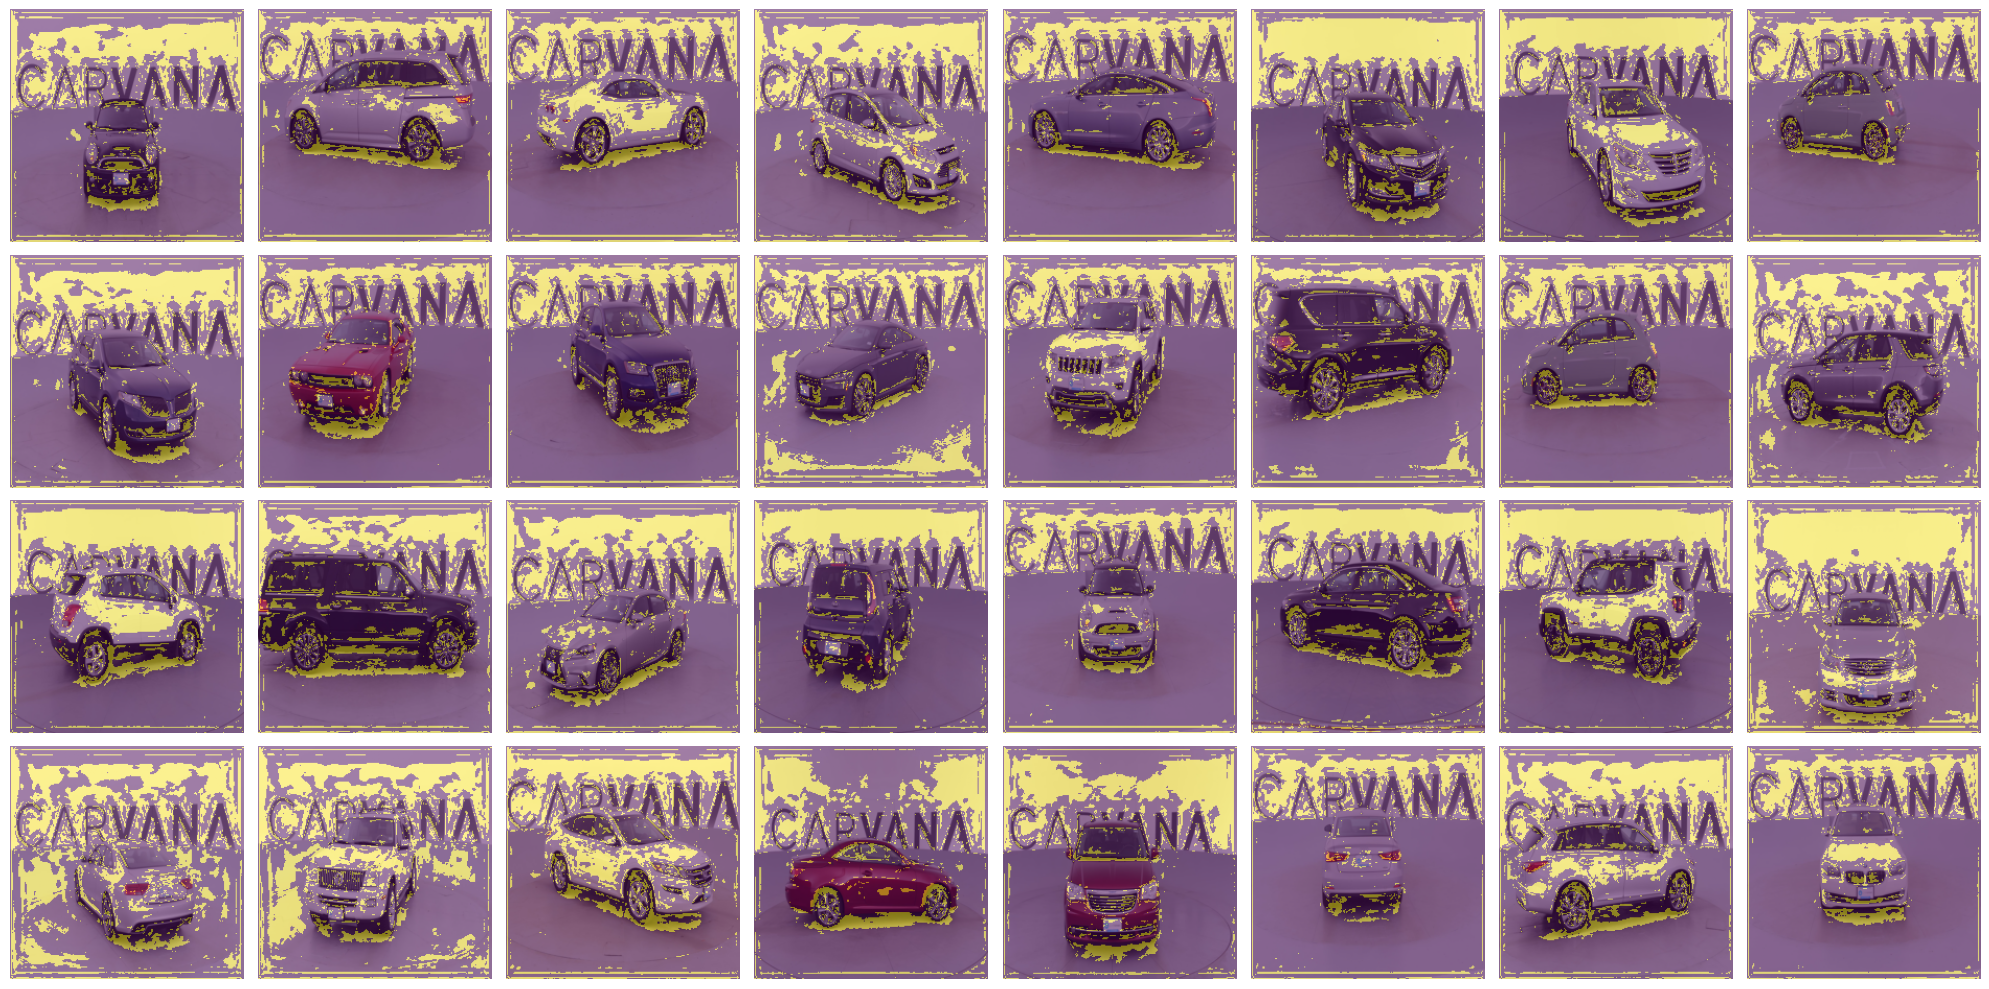

In [28]:
# Obtener un batch de imágenes y máscaras del val_loader
imgs_val, masks_val = next(iter(val_loader))

# Convertir las imágenes y máscaras al dispositivo adecuado
imgs_val = imgs_val.to(device, dtype=torch.float32)
masks_val = masks_val.to(device, dtype=torch.long)

# Convertir el modelo al dispositivo adecuado
model = model.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()
    
imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [37]:
train(model, optimizer, scheduler, epochs=epochs, store_every=25)

Modelo en dispositivo: cuda:0
Epoch 1/1, Batch 25, Train Cost: 0.2289, Train Accuracy: 0.9148, Validation Cost: 1.1249, Validation Accuracy: 0.8741, DICE: 0.6110, IoU: 0.4411
Epoch 1/1, Batch 50, Train Cost: 0.1418, Train Accuracy: 0.9470, Validation Cost: 0.7303, Validation Accuracy: 0.7580, DICE: 0.6293, IoU: 0.4593
Epoch 1/1, Batch 75, Train Cost: 0.1042, Train Accuracy: 0.9608, Validation Cost: 0.0313, Validation Accuracy: 0.9877, DICE: 0.9705, IoU: 0.9427
Epoch 1/1, Batch 100, Train Cost: 0.0840, Train Accuracy: 0.9682, Validation Cost: 0.0212, Validation Accuracy: 0.9917, DICE: 0.9803, IoU: 0.9613
Epoch 1/1, Batch 125, Train Cost: 0.0713, Train Accuracy: 0.9730, Validation Cost: 0.0198, Validation Accuracy: 0.9922, DICE: 0.9815, IoU: 0.9636


### Evaluamos nuestro modelo

torch.Size([32, 224, 224])


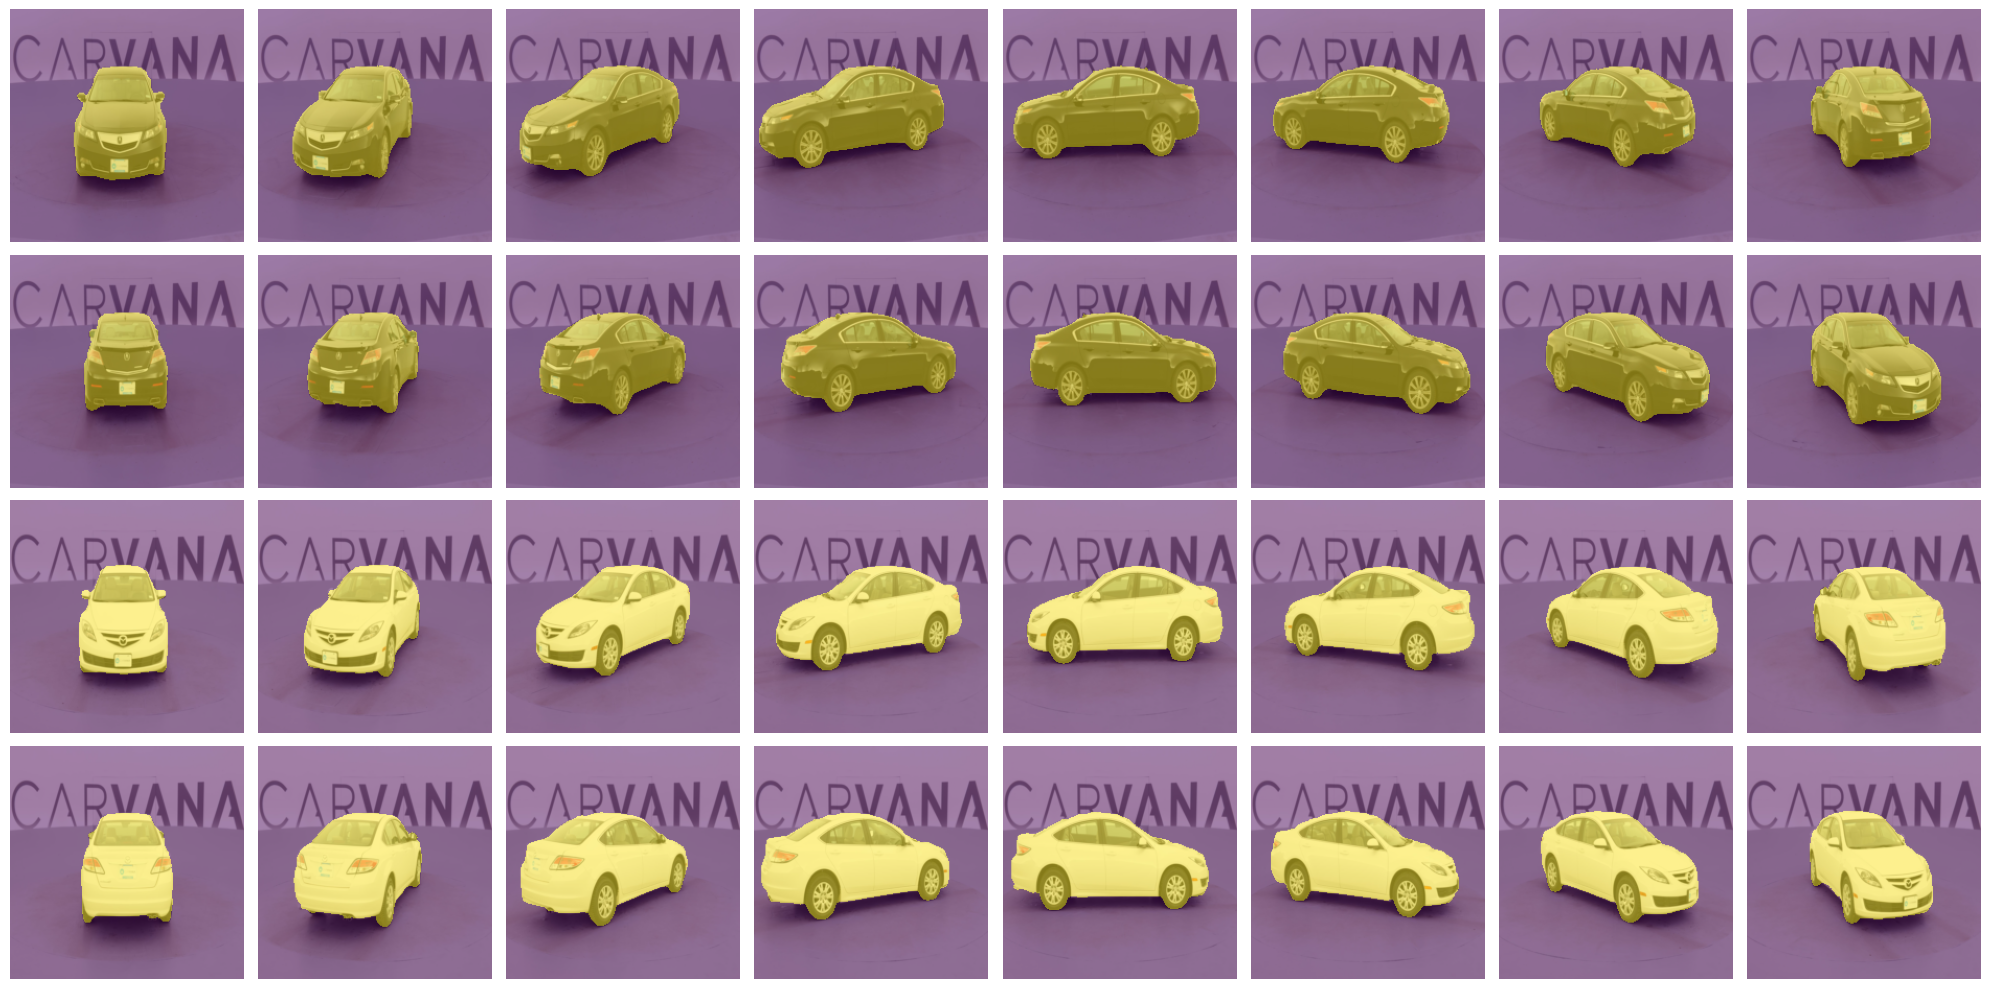

In [34]:
test_set = Car_Dataset(TEST_PATH,
                       imgs_transform=transform_data,
                       mask_transform=transform_data)
test_loader = DataLoader(test_set, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Obtener un batch de imágenes y máscaras del val_loader
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)

# Convertir el modelo al dispositivo adecuado
model = model.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()
    
imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))

